In [1]:
import pandas as pd
import numpy as np

from source.report import report_points, report_victory, yearly_wrapper

from sklearn.metrics import log_loss

In [5]:
logit = pd.read_csv('oof/2021_men_logit_2019.csv')
boost = pd.read_csv('oof/2021_men_xgboost_2019.csv')

logit.head()

,delta_Score,delta_opp_score,delta_Stl,delta_off_rating,delta_def_rating,delta_DR_edge,delta_OR,delta_TO,delta_Rank,delta_high_seed,...,delta_L2W_FGM_perc,delta_L2W_possessions,delta_L2W_Away,seed_round1,seed_round2,off_edge_Seed,def_edge_Seed,true_label,oof_pred,Season
0,1.226103,3.775735,3.762868,-0.481062,4.451246,-0.126417,-0.889706,0.115809,-30.870968,0.300000,...,-0.049924,-3.164583,0.083333,0,0,-124.370317,-96.579032,1,0.730690,2019
1,1.928977,1.490530,-2.147727,4.147717,3.069614,0.132195,2.587121,0.826705,10.516129,0.077778,...,-0.026384,4.268750,-0.250000,0,0,10.217245,2.999915,1,0.409959,2019
2,-12.401961,-3.019608,0.994652,-9.037284,2.389414,-0.027391,1.314617,1.522282,14.241935,-0.269231,...,-0.017908,-4.461250,-0.100000,0,0,29.488464,49.432074,1,0.349485,2019
3,2.505515,4.273897,1.564338,-3.496172,1.271964,0.014523,2.503676,2.500000,-62.032258,0.583333,...,-0.095205,4.862500,0.600000,1,0,-101.985584,-122.003461,1,0.774787,2019
4,-14.106549,7.423265,-0.029326,-14.923743,13.369404,-0.067894,-0.319648,3.087977,199.661290,-0.333333,...,0.066176,-6.300000,-0.166667,0,0,269.749523,293.064600,0,0.012773,2019


In [6]:
boost.head()

,T1_Score,T2_Score,T1_Ast,T2_Ast,T1_Blk,T2_Blk,T1_Away,T2_Away,T1_DR,T2_DR,...,T2_low_seed,T1_L2W_Score,T2_L2W_Score,T1_L2W_FGM_perc,T2_L2W_FGM_perc,T1_L2W_TO_perposs,T2_L2W_TO_perposs,true_label,oof_pred,Season
0,78.882353,77.656250,14.411765,14.500000,4.764706,2.468750,0.323529,0.437500,21.941176,25.125000,...,0.903226,75.500000,82.25,0.435673,0.485597,0.131478,0.146759,1,0.681915,2019
1,71.656250,69.727273,13.843750,12.000000,4.750000,4.787879,0.187500,0.212121,24.593750,24.000000,...,0.750000,66.666667,63.25,0.378378,0.404762,0.180059,0.220975,1,0.495860,2019
2,68.264706,80.666667,12.235294,14.969697,3.705882,3.909091,0.294118,0.424242,22.852941,28.060606,...,0.903226,67.800000,76.00,0.459770,0.477679,0.184284,0.151275,1,0.441112,2019
3,74.911765,72.406250,12.882353,11.500000,4.264706,3.937500,0.352941,0.343750,25.941176,25.718750,...,0.866667,67.000000,74.25,0.407143,0.502347,0.178236,0.167590,1,0.845943,2019
4,74.741935,88.848485,13.935484,18.212121,3.645161,5.484848,0.225806,0.393939,23.096774,29.090909,...,0.966667,78.333333,73.50,0.566176,0.500000,0.220667,0.183870,0,0.030000,2019


In [10]:
log_pred = logit[['true_label', 'oof_pred']].copy()
log_pred.columns = ['true_label_logit', 'logit_pred']
xgb_pred = boost[['true_label', 'oof_pred']].copy()
xgb_pred.columns = ['true_label', 'xgb_pred']

all_pred = pd.concat([log_pred, xgb_pred], axis=1)

assert (all_pred.true_label_logit == all_pred.true_label).all()
del all_pred['true_label_logit']

all_pred.head()

,logit_pred,true_label,xgb_pred
0,0.730690,1,0.681915
1,0.409959,1,0.495860
2,0.349485,1,0.441112
3,0.774787,1,0.845943
4,0.012773,0,0.030000


In [16]:
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

print(f'Logit: \t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.true_label)}')
print(f'Xgb: \t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.true_label)}')
print(f'Mean: \t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.true_label)}')

all_pred.head()

Logit: 	0.4799446151088922
Xgb: 	0.4633245922706355
Mean: 	0.46945322001753953


,logit_pred,true_label,xgb_pred,accord_win,accord_loss,accord,mean_pred
0,0.730690,1,0.681915,1,0,1,0.706303
1,0.409959,1,0.495860,0,1,1,0.452910
2,0.349485,1,0.441112,0,1,1,0.395298
3,0.774787,1,0.845943,1,0,1,0.810365
4,0.012773,0,0.030000,0,1,1,0.021386


In [38]:
all_pred['boostsure'] = all_pred.xgb_pred

all_pred.loc[((all_pred.logit_pred > 0.65) & (all_pred.xgb_pred > 0.65)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.35) & (all_pred.xgb_pred < 0.35)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.true_label)}')

all_pred.head()

Boost sure: 	0.4396978088085458


,logit_pred,true_label,xgb_pred,accord_win,accord_loss,accord,mean_pred,65_lim,boostsure,boostunsure
0,0.730690,1,0.681915,1,0,1,0.706303,0.931915,0.831915,0.681915
1,0.409959,1,0.495860,0,1,1,0.452910,0.495860,0.495860,0.445860
2,0.349485,1,0.441112,0,1,1,0.395298,0.441112,0.441112,0.441112
3,0.774787,1,0.845943,1,0,1,0.810365,0.970000,0.970000,0.845943
4,0.012773,0,0.030000,0,1,1,0.021386,0.030000,0.030000,0.030000


In [39]:
all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.65) & (all_pred.xgb_pred < 0.65)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.35) & (all_pred.xgb_pred > 0.35)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

print(f'Boost sure: \t{log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.true_label)}')

all_pred.head()

Boost sure: 	0.44178643116821315


,logit_pred,true_label,xgb_pred,accord_win,accord_loss,accord,mean_pred,65_lim,boostsure,boostunsure,avg_boost
0,0.730690,1,0.681915,1,0,1,0.706303,0.931915,0.831915,0.681915,0.831915
1,0.409959,1,0.495860,0,1,1,0.452910,0.495860,0.495860,0.445860,0.452910
2,0.349485,1,0.441112,0,1,1,0.395298,0.441112,0.441112,0.441112,0.441112
3,0.774787,1,0.845943,1,0,1,0.810365,0.970000,0.970000,0.845943,0.970000
4,0.012773,0,0.030000,0,1,1,0.021386,0.030000,0.030000,0.030000,0.030000


2015
Accord: 	0.9047619047619048
Logit: 		0.48379328156039486
Xgb: 		0.5048215608530948
Mean: 		0.49031337716749496
Boost sure: 	0.49854317473472903
Boost sure+mean: 0.4947355136923139
No uncertain: 0.488459400282215
Accuracy train: 		 0.7857
Accuracy test: 			 0.7857
Logloss train: 			 0.4885
Logloss test: 			 0.4985
Unsure train: 			 19.8413%
Unsure test: 			 30.1587%


________________________________________


2016
Accord: 	0.9206349206349206
Logit: 		0.5544873602351204
Xgb: 		0.5360934490137939
Mean: 		0.5428295012374884
Boost sure: 	0.5343661995666896
Boost sure+mean: 0.540564540797164
No uncertain: 0.532403506148554
Accuracy train: 		 0.7302
Accuracy test: 			 0.7302
Logloss train: 			 0.5324
Logloss test: 			 0.5344
Unsure train: 			 13.4921%
Unsure test: 			 22.2222%


________________________________________


2017
Accord: 	0.9523809523809523
Logit: 		0.49096470397333225
Xgb: 		0.4873674890004133
Mean: 		0.4871267177641976
Boost sure: 	0.4809914246697549
Boost sure+mean: 0.47

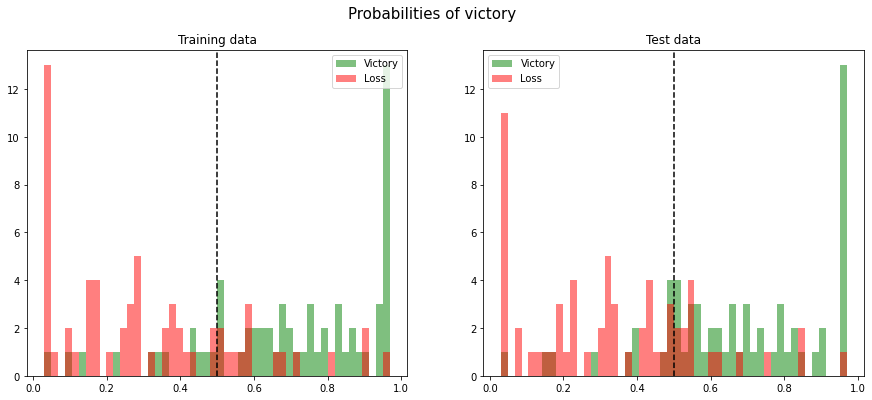

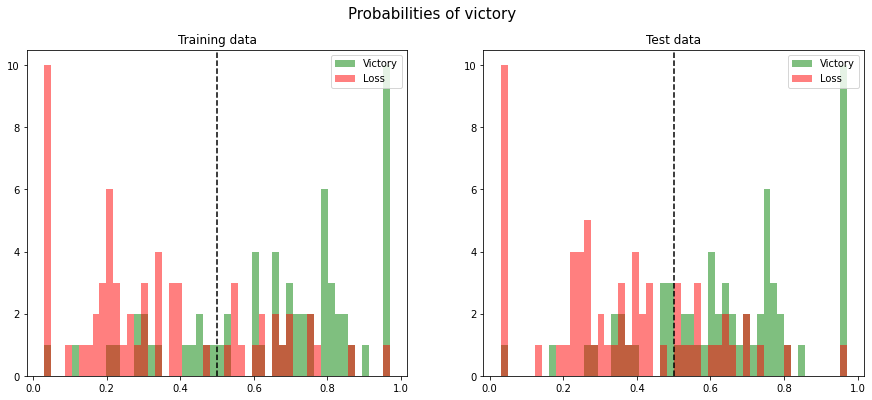

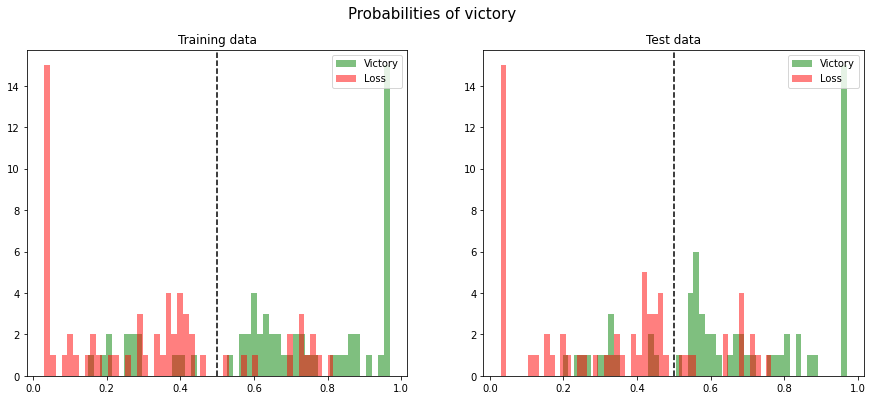

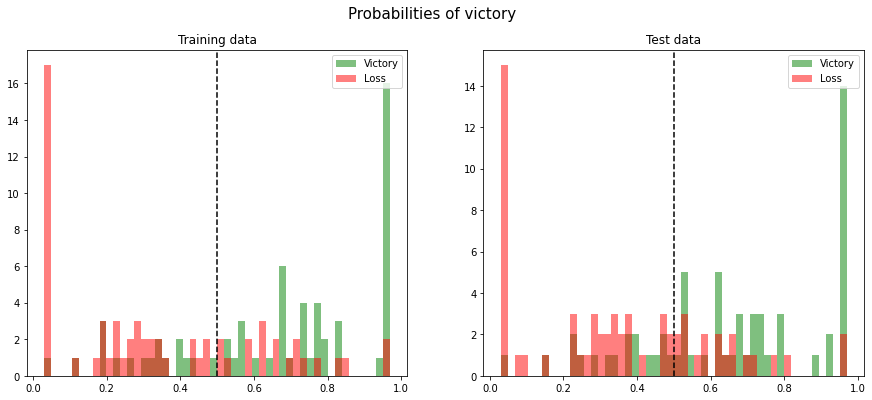

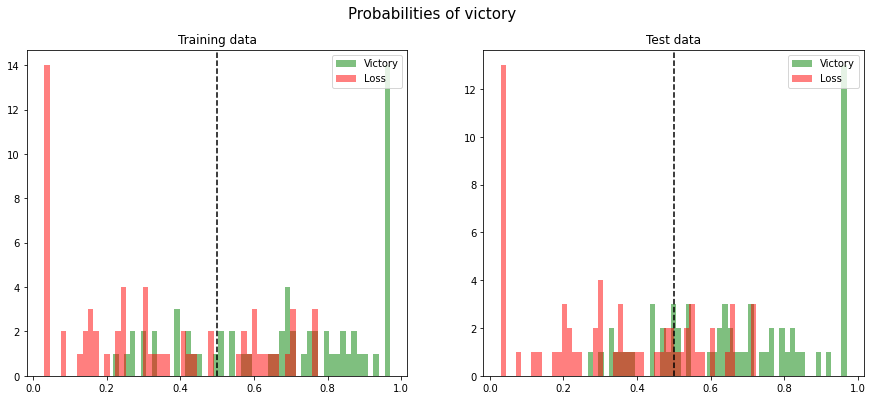

In [11]:
for yr in [2015, 2016, 2017, 2018, 2019]:
    lim = 0.35
    
    logit = pd.read_csv(f'oof/2021_men_logit_{yr}.csv')
    boost = pd.read_csv(f'oof/2021_men_xgboost_{yr}.csv')
    log_pred = logit[['true_label', 'oof_pred']].copy()
    log_pred.columns = ['true_label_logit', 'logit_pred']
    xgb_pred = boost[['true_label', 'oof_pred']].copy()
    xgb_pred.columns = ['true_label', 'xgb_pred']

    all_pred = pd.concat([log_pred, xgb_pred], axis=1)

    assert (all_pred.true_label_logit == all_pred.true_label).all()
    del all_pred['true_label_logit']
    all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

    all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
    all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
    all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)
    
    all_pred['boostsure'] = all_pred.xgb_pred

    all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
    all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
    all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)
    
    all_pred['avg_boost'] = all_pred.boostsure

    all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
                  (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
    all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
                  (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
    all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)
    
    all_pred['no_uncertain'] = all_pred.boostsure
    
    all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
                  ((all_pred.logit_pred < 0.5+lim) | (all_pred.xgb_pred < 0.5+lim))), 'no_uncertain'] = all_pred['no_uncertain'] + 0.05
    all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
                  ((all_pred.logit_pred > 0.5-lim) | (all_pred.xgb_pred > 0.5-lim))), 'no_uncertain'] = all_pred['no_uncertain'] - 0.05
    all_pred['no_uncertain'] = np.clip(all_pred['no_uncertain'], 0.03, 0.97)
    
    print(yr)
    print(f'Accord: \t{all_pred.accord.mean()}')
    print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.true_label)}')
    print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.true_label)}')
    print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.true_label)}')
    print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.true_label)}')
    print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.true_label)}')
    print(f'No uncertain: {log_loss(y_pred=all_pred.no_uncertain, y_true=all_pred.true_label)}')
    report_victory(all_pred.true_label, all_pred.true_label, all_pred.no_uncertain, all_pred.boostsure, probs=True, plot=True)
    print('\n')
    print('_'*40)
    print('\n')

2019
Accord: 	0.8973214285714286
Logit: 		0.5339355566844367
Xgb: 		0.5300477410100618
Mean: 		0.5268661078250426
Boost sure: 	0.5313515822484248
Boost sure+mean: 0.5311267109947004
Accuracy train: 		 0.7252
Accuracy test: 			 0.7252
Logloss train: 			 0.5314
Logloss test: 			 0.5314
Unsure train: 			 27.7282%
Unsure test: 			 27.7282%


________________________________________




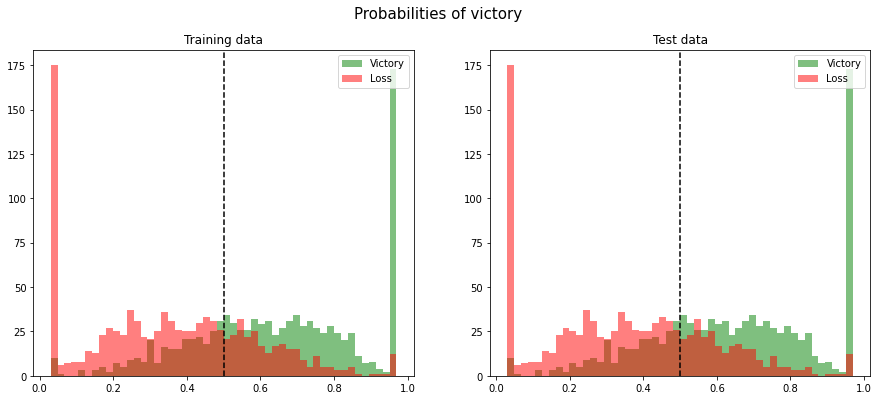

In [52]:
logit = pd.read_csv(f'oof/2021_men_logit_oof.csv')
boost = pd.read_csv(f'oof/2021_men_xgb_oof.csv')
log_pred = logit[['true_label', 'oof_pred']].copy()
log_pred.columns = ['true_label_logit', 'logit_pred']
xgb_pred = boost[['true_label', 'oof_pred']].copy()
xgb_pred.columns = ['true_label', 'xgb_pred']

all_pred = pd.concat([log_pred, xgb_pred], axis=1)

assert (all_pred.true_label_logit == all_pred.true_label).all()
del all_pred['true_label_logit']
all_pred['mean_pred'] = (all_pred['logit_pred'] + all_pred['xgb_pred']) / 2

all_pred['accord_win'] = np.where((all_pred['logit_pred'] > 0.50) & (all_pred['xgb_pred'] > 0.50), 1, 0)
all_pred['accord_loss'] = np.where((all_pred['logit_pred'] < 0.50) & (all_pred['xgb_pred'] < 0.50), 1, 0)
all_pred['accord'] = np.where(all_pred['accord_win'] + all_pred['accord_loss'] > 0, 1, 0)

all_pred['boostsure'] = all_pred.xgb_pred

all_pred.loc[((all_pred.logit_pred > 0.5+lim) & (all_pred.xgb_pred > 0.5+lim)), 'boostsure'] = all_pred['boostsure'] + 0.15
all_pred.loc[((all_pred.logit_pred < 0.5-lim) & (all_pred.xgb_pred < 0.5-lim)), 'boostsure'] = all_pred['boostsure'] - 0.15
all_pred['boostsure'] = np.clip(all_pred['boostsure'], 0.03, 0.97)

all_pred['avg_boost'] = all_pred.boostsure

all_pred.loc[((all_pred.logit_pred > 0.5) & (all_pred.xgb_pred > 0.5) & 
              (all_pred.logit_pred < 0.5+lim) & (all_pred.xgb_pred < 0.5+lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred.loc[((all_pred.logit_pred < 0.5) & (all_pred.xgb_pred < 0.5) & 
              (all_pred.logit_pred > 0.5-lim) & (all_pred.xgb_pred > 0.5-lim)), 'avg_boost'] = all_pred['mean_pred']
all_pred['avg_boost'] = np.clip(all_pred['avg_boost'], 0.03, 0.97)

print(yr)
print(f'Accord: \t{all_pred.accord.mean()}')
print(f'Logit: \t\t{log_loss(y_pred=all_pred.logit_pred, y_true=all_pred.true_label)}')
print(f'Xgb: \t\t{log_loss(y_pred=all_pred.xgb_pred, y_true=all_pred.true_label)}')
print(f'Mean: \t\t{log_loss(y_pred=all_pred.mean_pred, y_true=all_pred.true_label)}')
print(f'Boost sure: \t{log_loss(y_pred=all_pred.boostsure, y_true=all_pred.true_label)}')
print(f'Boost sure+mean: {log_loss(y_pred=all_pred.avg_boost, y_true=all_pred.true_label)}')
report_victory(all_pred.true_label, all_pred.true_label, all_pred.boostsure, all_pred.boostsure, probs=True, plot=True)
print('\n')
print('_'*40)
print('\n')